# Boundary Conditions

In this workbook we are going to modify our fast checkerboard *SOR* solver so that it can manage boundary conditions.

Remember we are solving
$$u_{xx}+u_{yy}=0$$
The boundary conditons can be
* **Dirichlet** boundary conditions where a value of the unknown, _u_, is specified, e.g. $$u(0,y)=273$$
* **Neumann** boundary conditions where a value of the derivative, _u<sub>x</sub>_, is specified. e.g. $$u_x(0,y)=0.$$
* **Robin** boundary conditions where the value of a function of the unknown and the derivative is specified, e.g. $$u_x(0,y)-2u(0,y)=1.$$

## Neumann boundary conditions
We have already implemented a **Dirichlet** boundary condition in our solver, and **Robin** boundary conditions are very rare, so let us consider **Neumann** conditions.

Supose we have
$$u_x(0)=0$$
Since we are already using a 2nd order central finite difference approximation, it seems best to do the same for this partial derivative too,
$$\frac{\partial u}{\partial x} \approx \frac{u_W-u_E}{2\Delta x}.$$
At the boundary
$$\frac{\partial u}{\partial x} =0$$ so
$$0 = \frac{u_W-u_E}{2\Delta x} \implies u_W=u_E.$$
This is the so-called _symmetry_ boundary condition.


### updating the Grid Class
We are going to need some flags that tell us if a boundary is a Neumann BC or a Dirichlet BC, so the `Grid` class needs extending.

We can define some flags DIRICHLET_BC, NEUMANN_BC and BC_NAME within the class, give every grid left, right, top and bottom flags which are set to *Dirichlet* by default and write a little function to specify boundaries and annother to report them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        
        # boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
    
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)
        boundaries = self.report_BC()
        return describe + '\nBoundaries conditions are - ' + boundaries

In [2]:
test = Grid(11,11)
test.set_Neumann_bc('right')
print(test)

Uniform 11x11 grid from (0.0, 0.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Neumann, top: Dirichlet, bottom: Dirichlet.


## Indirect adressing.
The SOR solver loops over all the interior cells in `u_new` using whole array opperations.

       u_new.flat[centre[::2]] = (1-omega) * u_new.flat[centre[::2]] + \
                                    omega * C_beta*(u_new.flat[north[::2]]+ \
                                    u_new.flat[south[::2]]+ \
                                    beta_sq*(u_new.flat[east[::2]]+ \
                                             u_new.flat[west[::2]]))

We call this **indirect** adressing because the locations in `u_new` are given by the entries in the `centre[]`, `north[]`, `south[]`, `east[]` and `west[]` arrays.  The good news is that this means only need to change the cells refered to in the `east[]` array on the left hand boundary if we want to implement the Neumann boundary condition _u<sub>x</sub>=0_.

The bit of the SOR code that needs modifying is the loop over the interior points that builds the lists.

    for j in range(1,mesh.Nj-1):
        for i in range(1,mesh.Ni-1):
            k=i+offset*j  # calculate the k value
            # save the south, west, centre, east and north points
            centre.append(k)
            north.append(k+offset)
            east.append(k+1)
            south.append(k-offset)
            west.append(k-1)

If we are next to a boundary **and** it's a Neumann boundary condition we need to adjust the pointer to point to the interior cell. So the west cell would be at k+1 and the east cell at k-1.




In [3]:
def SOR(mesh,tol=0.5e-7,maxit=10000):
    '''Sucessive over Relaxation method for the solution of
    the Laplace equation with checkerboarding.  The solver 
    assumes a uniform Cartesian mesh and uses the optimal
    value of the acceleration parameter, omega.
    
    The method works on the grid stored in the mesh object.  
    It will continue itterating until the relative difference 
    between u^{n+1} and u^n is less than tol. It will also stop 
    if we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated
            
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''

    # calculate the optimal value of omega
    lamda = (np.cos(np.pi/mesh.Ni)+np.cos(np.pi/mesh.Nj))**2/4
    omega = 2/(1+np.sqrt(1-lamda))

    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # build the list of k values    
    offset = mesh.u.shape[1] # how far away are j+1 and j-1

    # create some empty lists
    centre = []; north = []; east = []; south=[]; west = []  
    # loop over all the interior points
    for j in range(1,mesh.Nj-1):
        for i in range(1,mesh.Ni-1):
            k=i+offset*j  # calculate the k value
            
            # save the centre point
            centre.append(k)
            
            # do the north boundary checking for a Neumann bounary condition
            if (j == mesh.Nj-2) and (mesh.BC[2]== mesh.NEUMANN_BC):
                north.append(k-offset)
            else:
                north.append(k+offset)
                
            # do the east boundary checking for a Neumann boundary condition
            if (i == mesh.Ni-2) and (mesh.BC[1]== mesh.NEUMANN_BC):
                east.append(k-1)
            else:
                east.append(k+1)
                
            # do the sound boundary checking for a Neumann boundary condition
            if (j==1) and (mesh.BC[3]== mesh.NEUMANN_BC):
                south.append(k+offset)
            else:
                south.append(k-offset)
                
            # do the west boundary checking for a Neumann boundary condition        
            if (i==1) and (mesh.BC[0]== mesh.NEUMANN_BC):
                west.append(k+1)
            else:
                west.append(k-1)
                
    # itteration
    for it in range(maxit):
        
        # red squares [::2] means from 0 to n in steps of 2, remember
        # we are taking alternate values from the lists centre, east,
        # north, west and south and using them as indicies into the 
        # u_new array.
        u_new.flat[centre[::2]] = (1-omega) * u_new.flat[centre[::2]] + \
                                    omega * C_beta*(u_new.flat[north[::2]]+ \
                                    u_new.flat[south[::2]]+ \
                                    beta_sq*(u_new.flat[east[::2]]+ \
                                             u_new.flat[west[::2]]))
        
        # black squares [1::2] means from 1 to n in steps of 2
        u_new.flat[centre[1::2]] = (1-omega) * u_new.flat[centre[1::2]] + \
                                    omega * C_beta*(u_new.flat[north[1::2]]+ \
                                    u_new.flat[south[1::2]]+ \
                                    beta_sq*(u_new.flat[east[1::2]]+ \
                                             u_new.flat[west[1::2]]))

        # compute the difference between the new and old solutions
        err = np.max(np.abs(mesh.u-u_new))/np.max(np.abs(mesh.u))
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Checkerboard Gauss-Seidel itteration failed to converge, error = {}'.format(err))
    return it+1,err

## The original test problem
Were going to use the same test problem as before to make sure it still works! 

$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 2 \\
u(x,1)&=0&0\le x\le 2 \\
u(0,y)&=0&0\le y \le 1\\
u(2,y)&=\sin 2\pi y&0\le y \le 1.
\end{align*}$$


In [4]:
def Example929(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(2.0,1.0)
    mesh.generate()
    # now the RHS boundary condition
    mesh.u[:,-1]=np.sin(2*np.pi*mesh.y[:,-1])
    return mesh

Uniform 161x81 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
Solver took 2.57 seconds.
Converged after 517 itterations, final residual is 4.911869522228329e-15


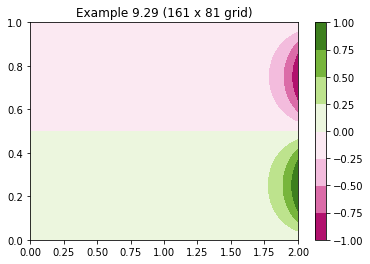

In [5]:
# Test problem on a fine grid
test = Example929(161,81)
print(test)

# run the solver
start = time.process_time()
itt, err = SOR(test,tol=0.5e-14)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
plt.show()

## A new test problem

Now we know we haven't changed the solution to our original test problem we need one that includes Neumann and Dirichlet boundary conditions.

### Porous Flow

Water seeping through a porous medium can be modelled using the Laplace equation.  If we have a "box" _z<sub>0</sub>_ meters tall and _s_ meters wide with a linear pressure gradient _h = z<sub>0</sub> + cx_ applied at the upper boundary, an impermeable base and constant flow boundaries on the left and right.  The pressure in the medium can be modlled as

$$h_{zz}+h_{xx}=0$$ with boundary conditions

$$h_z(x,0)=0,\,h_x(0,z)=0\text{ and }h_x(s,z)=0$$
and
$$h(x,z_0)=z_0+c x.$$

This test problem has an anlytical solution developed by Toth (1962):
$$h(x,z) = z_0+\frac{cs}{2}-\frac{4cs}{\pi^2}\sum_{m=0}^\infty 
\frac{\cos[(2m+1)\pi x/s]\cosh[(2m+1)\pi z/s]}
{(2m+1)^2\cosh[(2m+1)\pi z_0/s]}.$$

Let us consider a 200 wide by 100 m deep medium with _c_ = 0.176.

Uniform 101x51 grid from (0.0, 0.0) to (200.0, 100.0).
Boundaries conditions are - left: Neumann, right: Neumann, top: Dirichlet, bottom: Neumann.
Solver took 3.64 seconds.
Converged after 1737 itterations, final residual is 4.9461867869058823e-11


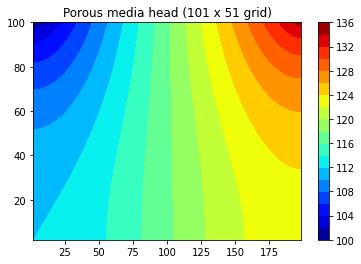

In [6]:
def porous(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(200.0,100.0)
    mesh.generate()
    # set the boundary conditions
    mesh.set_Neumann_bc('left')
    mesh.set_Neumann_bc('right')
    mesh.set_Neumann_bc('bottom')

    # now the top boundary condition
    mesh.u[-1,:]=100.0 + 0.176 * mesh.x[-1,:]
    return mesh    

ptest = porous(101,51)
print(ptest)

# run the solver
start = time.process_time()
itt, err = SOR(ptest,tol=0.5e-10,maxit=100000)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution Theleft, right and bottom cells contain nothing useful.

fig, ax1 = plt.subplots()
cmap = plt.get_cmap('jet')
cf = ax1.contourf(ptest.x[1:,1:-1],ptest.y[1:,1:-1],ptest.u[1:,1:-1],levels=21, cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Porous media head ({ptest.Ni} x {ptest.Nj} grid)')
plt.show()

# Further tests
We can compare this with the analytical solution, and conduct a mesh refinement study.  We're going to do the 2nd and need the integrate function again.  I'm interested in the integral of head at z=20.0 m from 25.0 to 175.0 m

In [7]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dx(mesh,x0,x1,y):
    '''Calculate U=\int_{1.0}^{1.95)u(x,0.25) dx  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i0,j = mesh.find((x0,y))
    i1,j = mesh.find((x1,y))

    # add 1 to i1 as we are going to use it as an upper 
    # bound forarray slicing
    i1 = i1 +1
    
    # integrate
    return integrate.simps(mesh.u[j,i0:i1],mesh.x[j,i0:i1])


We then need to set up a sequence of grids based on grid doubling. The number of grid points in each direction should be given by $$N =2^n m + 1$$ where n is the grid index and m is an integer.  For our problem we are going to use
$$N_i=2^n 20 + 1\text{ and }N_j=2^n 10 + 1$$

The following script creates a sequence of grids and solves them all.  The upper limit on the `range(5,-1,-1)` is the grid index of the finest grid.  Grid 5 takes about 20 minutes to run on my macbook pro. Grid 6, takes a much more reasonable three and a half minutes. 


In [ ]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(5,1,-1):
    ni = 20*2**grid_index + 1
    nj = 10*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    test = porous(ni,nj)
    print(test)
    
    # solve it with 12 d.p. precision and a lot of itterations
    start = time.process_time()
    itt, err = SOR(test,tol=0.5e-10,maxit=1000000)
    stop = time.process_time()
    print("The solver converged after {} itterations, it took {}, final residual is {}" \
          .format(itt,datetime.timedelta(seconds=int(stop-start)),err))

    # save dx and the integral
    dx_val.append(test.Delta_x())
    U_val.append(integrate_u_dx(test,75.0,125.0,25.0)/50)
    run_time.append(stop-start)
          
    print('Integrated value is ',U_val[-1],'\n')

Uniform 641x321 grid from (0.0, 0.0) to (200.0, 100.0).
Boundaries conditions are - left: Neumann, right: Neumann, top: Dirichlet, bottom: Neumann.


In [ ]:
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'\int_{75}^{125}h(x,25) dx')
analysis.plot(True,r'$\int_{75}^{125}h(x,25) dx$')

### Analysis

The refinement analysis shows
* _p_ = 1.0, so our 2nd order method has an apparent order of accuracy of 1.  Which is very disapointing.
* The GCI Ratios show that the solution on none of the girds is safely in the asymptotic region where the error is proprtional to Δx<sup>2</sup>.  This means need either
    * Our choice of monitor quanity is poor,
    * The SOR solution is not sufficiently converged (i.e. `tol` is too high), or
    * The grids are too coarse.

The We can try running the simulation on a finer grid, but this will need significantly longer to run.  Doubling the mesh size will increase the runtime by at least eight (2<sup>4</sup>) times. So we can expect it to run for almost three hours! 

We may need a faster solver